In [ ]:
import numpy as np
import pandas as pd
import keras
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
import matplotlib.pyplot as plt
%matplotlib inline
import json
import tensorflow as tf

Mounting Google drive for the Dataset :

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
! ls /content/gdrive/

'My Drive'


In [ ]:
# extracting folders from the zipfile

import zipfile

final_showdown_zip = '/content/gdrive/My Drive/final-showdown.zip'

zip_ref = zipfile.ZipFile(final_showdown_zip, 'r')
zip_ref.extractall('/content/gdrive/My Drive/final_showdown')
zip_ref.close()

In [ ]:
! ls -ltrh /content/gdrive/My\ Drive/final_showdown

total 13K
drwx------ 3 root root 4.0K Nov  2 07:59 Test
drwx------ 3 root root 4.0K Nov  2 07:59 Train
drwx------ 3 root root 4.0K Nov  2 08:00 Validation
-rw------- 1 root root  176 Nov  2 08:00 sample_submission.csv
-rw------- 1 root root  130 Nov  2 08:00 calibration.txt


In [ ]:
! ls -ltrh /content/gdrive/My\ Drive/final_showdown/Train/Train/1/imgs

total 668K
-rw------- 1 root root 84K Nov  2 07:59 008.jpg
-rw------- 1 root root 86K Nov  2 07:59 007.jpg
-rw------- 1 root root 85K Nov  2 07:59 006.jpg
-rw------- 1 root root 84K Nov  2 07:59 005.jpg
-rw------- 1 root root 84K Nov  2 07:59 004.jpg
-rw------- 1 root root 83K Nov  2 07:59 003.jpg
-rw------- 1 root root 81K Nov  2 07:59 002.jpg
-rw------- 1 root root 82K Nov  2 07:59 001.jpg


In [ ]:
import cv2

Function to Resize the image from (720,1280,3) to (180,320,3)  for faster computation still preserving the Image Aspect ratio

In [ ]:
def get_img(img_path, printer=True):
  original_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  if printer: print ("original dim:",original_img.shape)

  resized_img = cv2.resize(original_img, (320,180), interpolation=cv2.INTER_CUBIC)
  if printer: print ("resized dim:", resized_img.shape)

  return resized_img

original dim: (720, 1280, 3)
resized dim: (180, 320, 3)


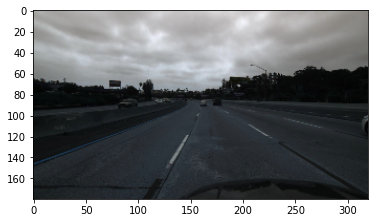

In [ ]:
# displaying a sample image
img_path = "/content/gdrive/My Drive/final_showdown/Train/Train/422/imgs/001.jpg"
resized_img = get_img(img_path)
plt.imshow(resized_img)

(720, 1280, 3)


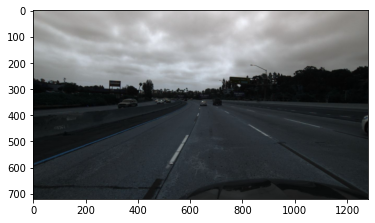

In [ ]:
prefix = "/content/gdrive/My Drive/final_showdown/Train/Train/422/imgs/001.jpg"
original_img = cv2.imread(prefix, cv2.IMREAD_COLOR)
print(original_img.shape)
plt.imshow(original_img)

**To Concatanate 8 Images in a sample for our TimeDistributed Layer**

In [ ]:
prefix = "/content/gdrive/My Drive/final_showdown/Train/Train/400/imgs/00"          ## Testing the Concatanation method

X_sample = []
for idx in range(1, 9):
  img_path = prefix + str(idx) + ".jpg"
  resized_img = get_img(img_path, printer=False)
  X_sample.append(resized_img)

print (np.array(X_sample).shape)

(8, 180, 320, 3)


**To Convert the Training data into Required format to feed the data into model.**

In [ ]:
main_prefix="/content/gdrive/My Drive/final_showdown/Train/Train/"
X_train_check=[]
for i in range(1,457):
  path=main_prefix+str(i)+"/imgs/00"
  X_sample = []
  for idx in range(1, 9):
    img_path = path + str(idx) + ".jpg"
    resized_img = get_img(img_path, printer=False)
    X_sample.append(resized_img)
  X_train_check.append(np.array(X_sample))


In [ ]:
#Checking Numbers:
#main_prefix="/content/gdrive/My Drive/final_showdown/Train/Train/"
#for i in range(1,457):
#  path=main_prefix+str(i)+"/imgs/00"
#  print(path)

In [ ]:
np.array(X_train_check).shape     ## Final  Shape to Feed into the Model 

(456, 8, 180, 320, 3)

**Extracting Velocity in X and Y Direction from the annotation file and made an numpy array with 2 cols [Velocity in X and Y] and 456 rows[No. of training data]**

In [ ]:
main_prefix="/content/gdrive/My Drive/final_showdown/Train/Train/"
y_train_check=[]
for i in range(1,457):
  path=main_prefix+str(i)+"/annotation.json"
  f = open(path,)  
  data = json.load(f) 
  f.close()
  y_train_check.append(np.array((data[0]["velocity"])))

In [ ]:
np.array(y_train_check).shape   ## Final Y Shape to feed into the model

(456, 2)

In [ ]:
print(np.array(y_train_check)[:5])

[[-1.22874695 -0.01014016]
 [-0.57906768 -0.05475482]
 [ 2.20549518  0.34804299]
 [ 0.06239713 -0.35931301]
 [ 1.15492596  0.57925854]]


In [ ]:
import tensorflow
from  tensorflow.keras.callbacks import  EarlyStopping
from keras.applications.vgg19 import VGG19
from keras.applications import Xception

In [ ]:
model=None    ## For Clearing model weights for retraining purposes

In [ ]:
import tensorflow as tf


**I have tested various pretrained models available in keras. They are Initialized below**


In [ ]:
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

vgg19 = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
xcep = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
inceptionresnet=tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3)
)
nasnet=tf.keras.applications.NASNetLarge(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
)

for layer in vgg.layers[:-4]:
    layer.trainable = False

for layer in inceptionresnet.layers[:-4]:
    layer.trainable = False

for layer in xcep.layers[:-4]:
    layer.trainable = False
for layer in nasnet.layers[:-4]:
    layer.trainable = False

for layer in nasnetmobile.layers[:-4]:
    layer.trainable = False
inception = InceptionV3( input_shape=(224, 224, 3),weights='imagenet', include_top=False)



In [ ]:

inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       ###Best Model in this Case was InceptionResNet V2
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,320,3)
)  
for layer in inceptionresnet.layers[:-4]:                                                       ###Training only the last 4 layers in the pretrained Model
    layer.trainable = False
# create a Sequential model
model = Sequential()

# add vgg model for 8 input images (keeping the right shape
model.add(TimeDistributed(inceptionresnet, input_shape=(8, 180, 320, 3)))                          ###Using TimeDistributed Layer to Feed the Image Sequence

# now, flatten  each output to send 8 outputs with one dimension to LSTM
model.add( TimeDistributed( Flatten()  ))
model.add(LSTM(256, activation='relu', return_sequences=False))                                   ##Added LSTM to Capture the Sequence Information
# finalize with standard Dense, Dropout...
model.add(Dense(64, activation='relu'))                                           ##Final Adding an Dense Layer
model.add(Dropout(.5))                                                              ##Dropouts to avoid overfitting

model.add(Dense(2))                                          ## Final Layer is of 2 Neurons [Velocity in X Direction and Y Direction]

model.compile(optimizer='adam', loss='mean_squared_error', metrics=tensorflow.keras.metrics.RootMeanSquaredError())

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 8, 4, 8, 1536)     54336736  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 8, 49152)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               50594816  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 104,948,130
Trainable params: 53,807,810
Non-trainable params: 51,140,320
________________________________

In [ ]:
r=model.fit(np.array(X_train_check),np.array(y_train_check),validation_split=0.2,batch_size=38,epochs=10)   #Model Fitting

Epoch 1/10
10/10 [==============================] - 39s 4s/step - loss: 16198.4971 - root_mean_squared_error: 127.2733 - val_loss: 285773.4688 - val_root_mean_squared_error: 534.5778
Epoch 2/10
10/10 [==============================] - 33s 3s/step - loss: 18529.8301 - root_mean_squared_error: 136.1243 - val_loss: 28752.9453 - val_root_mean_squared_error: 169.5669
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 5279.6880 - root_mean_squared_error: 72.6615 - val_loss: 5764.4849 - val_root_mean_squared_error: 75.9242
Epoch 4/10
10/10 [==============================] - 34s 3s/step - loss: 802.8940 - root_mean_squared_error: 28.3354 - val_loss: 306.2000 - val_root_mean_squared_error: 17.4986
Epoch 5/10
10/10 [==============================] - 34s 3s/step - loss: 133.0500 - root_mean_squared_error: 11.5347 - val_loss: 62.8992 - val_root_mean_squared_error: 7.9309
Epoch 6/10
10/10 [==============================] - 34s 3s/step - loss: 42.9769 - root_mean_squared_error: 

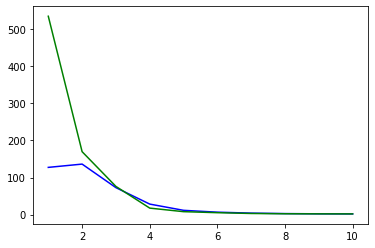

In [ ]:

plt.plot(np.arange(1,11),r.history["root_mean_squared_error"],c="blue")
plt.plot(np.arange(1,11),r.history["val_root_mean_squared_error"],c="green")
plt.show()

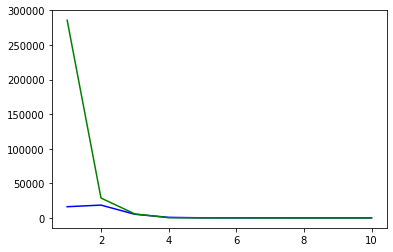

In [ ]:
plt.plot(np.arange(1,11),r.history["loss"],c="blue")
plt.plot(np.arange(1,11),r.history["val_loss"],c="green")
plt.show()

In [ ]:
print(np.array(X_train_check).shape)
print(np.array(y_train_check).shape)

(456, 8, 180, 320, 3)
(456, 2)


In [ ]:
##Model Shows no sign of overfitting ,Let us Try with Validation Data

**Validation File Preprocessing and Evaluating the Model** 

original dim: (720, 1280, 3)
resized dim: (180, 320, 3)


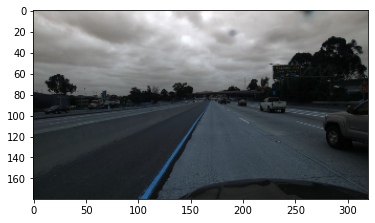

In [ ]:
img_path = "/content/gdrive/My Drive/final_showdown/Validation/Validation/1/imgs/001.jpg"
resized_img = get_img(img_path)
plt.imshow(resized_img)

In [ ]:
prefix = "/content/gdrive/My Drive/final_showdown/Validation/Validation/1/imgs/00"

X_sample = []
for idx in range(1, 9):
  img_path = prefix + str(idx) + ".jpg"
  resized_img = get_img(img_path, printer=False)
  X_sample.append(resized_img)

print (np.array(X_sample).shape)

(8, 224, 224, 3)


In [ ]:
## Validation:

val_path="/content/gdrive/My Drive/final_showdown/Validation/Validation/"
X_val_check=[]
for i in range(1,153):
  path=val_path+str(i)+"/imgs/00"
  X_sample = []
  for idx in range(1, 9):
    img_path = path + str(idx) + ".jpg"
    resized_img = get_img(img_path, printer=False)
    X_sample.append(resized_img)
  X_val_check.append(np.array(X_sample))

In [ ]:
print(np.array(X_val_check).shape)

(152, 8, 180, 320, 3)


In [ ]:
val_path="/content/gdrive/My Drive/final_showdown/Validation/Validation/"
y_val_check=[]
for i in range(1,153):
  path=val_path+str(i)+"/annotation.json"
  f = open(path,)  
  data = json.load(f) 
  f.close()
  y_val_check.append(np.array((data[0]["velocity"])))

In [ ]:
print(np.array(y_val_check).shape)

(152, 2)


In [ ]:
model.evaluate(np.array(X_val_check),np.array(y_val_check))

5/5 [==============================] - 5s 1s/step - loss: 3.1428 - root_mean_squared_error: 1.7728


[3.1427972316741943, 1.7727936506271362]

In [ ]:
# Model performed well on validation data and Didnt Overfit to the training Data. it is getting good rmse value 

**Test File Preprocessing and Predicting with the Model trained above for the submission**

original dim: (720, 1280, 3)
resized dim: (180, 320, 3)


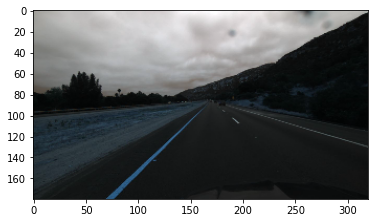

In [ ]:
img_path = "/content/gdrive/My Drive/final_showdown/Test/Test/1/imgs/001.jpg"
resized_img = get_img(img_path)
plt.imshow(resized_img)

In [ ]:
prefix = "/content/gdrive/My Drive/final_showdown/Test/Test/1/imgs/00"

X_sample = []
for idx in range(1, 9):
  img_path = prefix + str(idx) + ".jpg"
  resized_img = get_img(img_path, printer=False)
  X_sample.append(resized_img)

print (np.array(X_sample).shape)

(8, 224, 224, 3)


In [ ]:
## Test:

test_path="/content/gdrive/My Drive/final_showdown/Test/Test/"
X_test_check=[]
for i in range(1,153):
  path=test_path+str(i)+"/imgs/00"
  X_sample = []
  for idx in range(1, 9):
    img_path = path + str(idx) + ".jpg"
    resized_img = get_img(img_path, printer=False)
    X_sample.append(resized_img)
  X_test_check.append(np.array(X_sample))

In [ ]:
np.array(X_test_check).shape

(152, 8, 180, 320, 3)

In [ ]:
pred=model.predict(np.array(X_test_check))

In [ ]:
pred[:5,0]

array([-0.0031549 , -0.08914074,  0.27492866, -0.0031549 , -0.0031549 ],
      dtype=float32)

In [ ]:
pred.shape

(152, 2)

In [ ]:
np.sqrt(np.square(pred[0,0])+np.square(pred[0,1]))

0.4741853

In [ ]:
tryy=np.sqrt(np.square(pred[:,0])+np.square(pred[:,1]))

In [ ]:
tryy

array([0.7925565 , 0.7387196 , 0.47815722, 0.73622286, 0.5648356 ,
       0.6721199 , 0.6203748 , 0.8047121 , 0.7292711 , 0.4367201 ,
       0.7432231 , 0.6504092 , 0.7828618 , 0.6431134 , 0.6734463 ,
       0.80196047, 0.71982944, 0.71111447, 0.69318736, 0.56174105,
       0.68173206, 0.69699264, 0.7237349 , 0.7683477 , 0.66812575,
       0.6250052 , 0.4684317 , 0.6050662 , 0.72280926, 0.59799963,
       0.6599284 , 0.660718  , 0.6470506 , 0.75274247, 0.8139206 ,
       0.6965846 , 0.75768375, 0.75932056, 0.7889206 , 0.48741955,
       0.6178842 , 0.6576345 , 0.46079025, 0.4976153 , 0.5318848 ,
       0.5180508 , 0.5814669 , 0.68029433, 0.7951187 , 0.7256671 ,
       0.6438675 , 0.95612985, 0.87425274, 0.54976434, 0.83541435,
       0.82378536, 0.6566676 , 0.5464609 , 0.78237456, 0.7416387 ,
       0.7215961 , 0.7683659 , 0.6923518 , 0.739813  , 0.56174105,
       0.6587797 , 0.66863894, 0.49358404, 0.5683735 , 0.6130978 ,
       0.8105556 , 0.97794795, 0.5458259 , 0.7228262 , 4.87665

In [ ]:
output = pd.DataFrame({'ID':np.arange(1,153),'speed':tryy})
output.to_csv('inception-resized-10epoch.csv',index = False)

In [ ]:
output

,ID,speed
0,1,0.792557
1,2,0.738720
2,3,0.478157
3,4,0.736223
4,5,0.564836
...,...,...
147,148,0.864669
148,149,0.794170
149,150,0.756026
150,151,0.675260
